In [1]:
import tensorflow as tf
tf.__version__

'2.4.1'

In [2]:
# Check with exported model and if it is well trained
# these codes are from inference_from_saved_model_tf2_colab.ipynb

import io
import os
import scipy.misc
import numpy as np
import six
import time

from six import BytesIO

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import label_map_util

%matplotlib inline

def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path (this can be local or on colossus)

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
#   print(im_width, im_height)
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [3]:
# Path to label map file
PATH_TO_LABELS = os.path.join('/home001/yousung.choi/projects/project_coordination/workspace/training_demo/annotations','label_map.pbtxt')

# Number of classes the object detector can identify
NUM_CLASSES = 1

# Load the label map.
# Label maps map indices to category names, so that when our convolution
# network predicts `5`, we know that this corresponds to `king`.
# Here we use internal utility functions, but anything that returns a
# dictionary mapping integers to appropriate string labels would be fine
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

# 1: {'id': 1, 'name': 'book'},
with open(PATH_TO_LABELS, 'r') as f:
    print(f.read())
print(category_index)

item {
  id: 1
  name: 'Cursor'
}


{1: {'id': 1, 'name': 'Cursor'}}


In [4]:
start_time = time.time()
tf.keras.backend.clear_session()
detect_fn = tf.saved_model.load('/home001/yousung.choi/projects/project_coordination/workspace/training_demo/exported-models/3rd_trial_210323/saved_model')
# detect_fn = tf.saved_model.load('/home001/yousung.choi/projects/project_coordination/workspace/training_demo/exported-models/1st_trial/saved_model')
# detect_fn = tf.saved_model.load('/home/yousungchoi/projects/project_coordination/workspace/training_demo/exported-models/2nd_tria_320320/saved_model')
end_time = time.time()
elapsed_time = end_time - start_time
print('Elapsed time: ' + str(elapsed_time) + 's')

Elapsed time: 8.58157992362976s


In [5]:
# print(detect_fn.signatures['serving_default'].inputs)
print(detect_fn.signatures['serving_default'].inputs)
print(detect_fn.signatures['serving_default'].output_dtypes)
# print(detect_fn.signatures['serving_default'].output_shapes)

[<tf.Tensor 'input_tensor:0' shape=(1, None, None, 3) dtype=uint8>, <tf.Tensor 'unknown:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_0:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_1:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_2:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_3:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_4:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_5:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_6:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_7:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_8:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_9:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_10:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_11:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_12:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_13:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_14:0' shape=<unknown> dtype=resource>, <

### 여기서 Optical Flow 를 동시에 활용해보기 위해 Optical Flow options params 불러오기

In [6]:
import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt

In [94]:
orb = cv2.ORB_create(
    nfeatures=100,
    scaleFactor=1.5,
    nlevels=10,
    edgeThreshold=2,
    firstLevel=0,
    WTA_K=2,
    scoreType=cv2.ORB_HARRIS_SCORE,
    patchSize=2,
    fastThreshold=20,
)

orb2 = cv2.ORB_create(
    nfeatures=100,
    scaleFactor=1.5,
    nlevels=10,
    edgeThreshold=2,
    firstLevel=0,
    WTA_K=2,
    scoreType=cv2.ORB_FAST_SCORE,
    patchSize=2,
    fastThreshold=10,
)

akaze = cv2.AKAZE_create()
kaze = cv2.KAZE_create()

def get_features(gray):
    kp, descs = orb.detectAndCompute(gray, None)
    return np.array([np.array([k.pt]).astype(np.float32,) for k in kp])

def get_features2(gray):
    kp, descs = orb2.detectAndCompute(gray, None)
    return np.array([np.array([k.pt]).astype(np.float32,) for k in kp])

def get_features3(gray):
    kp, descs = akaze.detectAndCompute(gray, None)
    return np.array([np.array([k.pt]).astype(np.float32,) for k in kp])

def get_feature4(gray):
    kp, descs = kaze.detectAndCompute(gray, None)
    return np.array([np.array([k.pt]).astype(np.float32,) for k in kp])

## Machine learning 으로 찾은 Target 만큼 Optical Flow 로 따라가보기

In [101]:
# 읽은 동영상을 일괄 추론해서 MP4 로 저장하기

import os
import random
import cv2
from tqdm import tqdm

elapsed = []
# setting for Video input

# video_input = '/home001/yousung.choi/projects/project_coordination/tools/1_datasets/1_video/Rainbow_Test/new_test/1_calculator.mp4'
video_input = '/home001/yousung.choi/projects/project_coordination/tools/1_datasets/1_video/Rainbow_Test/210506_orb_input.mp4'
# video_input = '/home001/yousung.choi/projects/project_coordination/tools/1_datasets/1_video/Rainbow_Test/210517_orb_input.mp4'
# video_input = '/home001/yousung.choi/projects/project_coordination/tools/1_datasets/1_video/Rainbow_Test/9999_210421_optical_flow_test.mp4'
video_handle = cv2.VideoCapture(video_input)

# setting for Video output
# video_output = '/home001/yousung.choi/projects/project_coordination/tools/1_datasets/1_video/Rainbow_Test/9999_210421_optical_flow_test_output.mp4'
# video_output = '/home001/yousung.choi/projects/project_coordination/tools/1_datasets/1_video/Rainbow_Test/210517_orb_output_off10_win15.mp4'
video_output = '/home001/yousung.choi/projects/project_coordination/tools/1_datasets/1_video/Rainbow_Test/210506_orb_output_AKAZE.mp4'
# video_output = '/home001/yousung.choi/projects/project_coordination/tools/1_datasets/1_video/Rainbow_Test/210506_orb_output_off20_win15.mp4'
# video_output = '/home001/yousung.choi/projects/project_coordination/tools/1_datasets/1_video/Rainbow_Test/new_test/1_calculator_output.mp4'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
# out = cv2.VideoWriter(video_output, fourcc, 5.0, (720, 1600))
out = cv2.VideoWriter(video_output, fourcc, 5.0, (720, 1640))
# out = cv2.VideoWriter(video_output, fourcc, 5.0, (1080, 1920))
# out = cv2.VideoWriter(video_output, fourcc, 10.0, (720, 1560))

total_frm = np.arange(int(video_handle.get(cv2.CAP_PROP_FRAME_COUNT)))

# 추적 경로를 그리기 위함
color = np.random.randint(0, 255, (100, 3))
# 추적 선을 그리기 위함
lines = None
# 첫번째 frame 을 위함
not_detected = True
prevImage_partial = None

# image partial offset
offset = 50


# CalcOpticalFlowPyrLK 중지요건 설정 (??)
lk_params = dict(winSize = (15, 15),
                maxLevel = 5,
                criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

test_images = []
nextMv = np.zeros(shape = (0,1))
x_diffs = []

for frm_cnt in tqdm(total_frm):
    if video_handle.isOpened():
        ret, image_cv2 = video_handle.read()
        if (frm_cnt == 0):
            lines = np.zeros_like(image_cv2)
        # test skipping
#         if frm_cnt < 20:
#             continue
        
        if ret:
            image_draw = image_cv2
            image_np = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)
            image_gray = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2GRAY)

            if not_detected:
                input_tensor = np.expand_dims(image_np, 0)

                start_time = time.time()
                detections = detect_fn(input_tensor)
                end_time = time.time()
                elapsed.append(end_time - start_time)
                
                ## calculate object counted in output
                obj_cnt = len(np.where(detections['detection_scores'][0].numpy() > 0.8)[0])
            
                if obj_cnt:
                    ymin, xmin, ymax, xmax = detections['detection_boxes'][0][0].numpy()
                    height, width, cl = image_np.shape
                    ymin = int(ymin * height) - offset
                    ymax = int(ymax * height) + offset
                    xmin = int(xmin * width) - offset
                    xmax = int(xmax * width) + offset
                    
                    initial_size = [xmax - xmin, ymax - ymin]
                    print("initial size of default detection : " , initial_size[0], initial_size[1])
                
                    # Test code to draw rectangle in image
    #                 height, width, cl = image_np.shape
    #                 image_np_with_detections = cv2.rectangle(image_np_with_detections, (int(xmin * width), int(ymin * height)), (int(xmax * width), int(ymax * height)), (0,255,0), 3)
    #                 plt.imshow(image_np_with_detections)
                    
                    # 현재 Frame update with detections
                    viz_utils.visualize_boxes_and_labels_on_image_array(
                          image_draw,
                          detections['detection_boxes'][0].numpy(),
                          detections['detection_classes'][0].numpy().astype(np.int32),
                          detections['detection_scores'][0].numpy(),
                          category_index,
                          use_normalized_coordinates=True,
                          max_boxes_to_draw=200,
                          min_score_thresh=.80,
                          agnostic_mode=False)
                    
                    # 다음 프레임에 사용할 orb Feature 뽑기
                    # 추후 image 자를 때 image 영역이 충분한지 고려해야 함 -> 베젤 쪽 이미지는 영역부족으로 잘리지 않을 수 있음.
                    prevImage_partial = image_gray[ymin:ymax, xmin:xmax].copy()                        
                        
                    prevPt = get_features3(prevImage_partial)
                    print("prevPt shape : ", prevPt.shape)
                    
                    
                    # detect 한 영역을 기준으로 feature 뽑았으면, 다음 frame에서는 detect 안하게 만듬.
                    if (prevPt.shape[0] != 0):
                        not_detected = False
                
                # if not obj_cnt (detect 안된 상황에서 object 마저 없는 경우)
                else :
                    print("No objects (frm cnt) : ", frm_cnt)
                    
            # if once detected (detection이 제대로 이루어 졌다면. optical flow 해야지)
            else : 
                nextImage_partial = image_gray[ymin:ymax, xmin:xmax].copy()
                nextImage_draw = image_draw[ymin:ymax, xmin:xmax, :].copy()
                
                # Optical Flow 로 next frame 의 coner 찾기
#                 print(prevImage_partial.shape, nextImage_partial.shape)
                nextPt, status, err = cv2.calcOpticalFlowPyrLK(prevImage_partial, nextImage_partial, prevPt, None, **lk_params)
                
                # 대응점이 있는 코너 선별
                if prevPt is not None and nextPt is not None:
                    prevMv = prevPt[status == 1]
                    nextMv = nextPt[status == 1]
                else:
                    print("None frame has come! :" , frm_cnt)
                    continue
                
                if prevMv.shape[0] == 0 or nextMv.shape[0] == 0:
                    print("Empty , frame_num[{}] shape[prevMv : {}, nextMv : {}]".format(frm_cnt,prevMv.shape, nextMv.shape))
                    cv2.putText(image_draw, 'Frames {0:1d}'.format(frm_cnt+1), (20,20), cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,0,0),2,cv2.LINE_AA)
                    out.write(image_draw)
                    not_detected = True
                    continue
                    
                for i, (p, n) in enumerate(zip(prevMv, nextMv)):
                    px, py = p.ravel()
                    nx, ny = n.ravel()
                    
                    # 이전 코너와 새로운 코너에 선그리기
#                     cv2.line(lines, (px, py), (nx, ny), color[i].tolist(), 2)
                    
                    # 새로운 코너에 점그리기
                    cv2.circle(nextImage_draw, (nx, ny), 2, color[i].tolist(), -1)
                    
                    
                # 그었던 새로운 정보들을 기존 Image 에 다시 Mapping
                avg_x, avg_y = prevMv.mean(axis=0)
                avg_x_next, avg_y_next = nextMv.mean(axis=0)
                x_diffs.append(avg_x_next - avg_x)
        
                # Red Dot Add to check center point of Features
                cv2.circle(nextImage_draw, (avg_x_next, avg_y_next), 2, (0, 0, 255), -1)
                cv2.rectangle(nextImage_draw, (0, 0), (nextImage_draw.shape[0], nextImage_draw.shape[1]), (0, 0, 255), 3)
                 
                # add Lines which if avg_pointers are really tracking
                old_rect = [round((xmin + xmax) / 2), round((ymin + ymax) / 2)]
                
                # 기존 point 에서 변경점만을 Shift 하며 쫒아가니, 못쫒아가는 지점이 나오므로
#                 ymin = ymin + int(np.ceil(avg_y_next - avg_y))
#                 ymax = ymin + 125
#                 xmin = xmin + int(np.ceil(avg_x_next - avg_x))
#                 xmax = xmin + 125
                
                # 이미지 변경 시점은, Old frame 기준으로 update 해줌.
                # 대신 여기서 필요한 것은 현재 기준으로 잡은 윈도우의 영역을 표시해줘야 가시적으로 보일 것 같음.
                image_draw[ymin:ymax, xmin:xmax:,:] = nextImage_draw.copy()
    
                # 변경된 지점을 항상 가운데로 두고 Tracking 할 수 있도록 중앙점 자체를 변경해서 진행
#                 ymin = ymin + int(avg_y_next) - int(initial_size[1]/2) 
                ymin = ymin + int(avg_y_next) - int(avg_y)
                ymax = ymin + initial_size[1]
#                 xmin = xmin + int(avg_x_next) - int(initial_size[0]/2)
                xmin = xmin + int(avg_x_next) - int(avg_x)
                xmax = xmin + initial_size[0]
#                 lines = cv2.line(lines, (old_rect[0], old_rect[1]), (round((xmin + xmax) / 2), round((ymin + ymax) / 2)), (0, 0, 255), 3)
                
                lines = cv2.line(lines, (old_rect[0], old_rect[1]), (round((xmin + xmax) / 2), round((ymin + ymax) / 2)), (255, 0, 255), 3)
                w = 10
                image_draw = cv2.addWeighted(image_draw,float(100-w) * 0.01, lines, float(w) * 0.01,0)
                image_draw = cv2.add(image_draw, lines)
#                 image_draw += lines
        
                # 새로이 구한 사각형 기준으로 Prev Pointer 들을 다시 뽑아줌 (다음 Frame에서의 계산을 위해)
                prevImage_partial = image_gray[ymin:ymax, xmin:xmax].copy()
                prevPt = get_features3(prevImage_partial)
                if (prevPt.shape[0] == 0):
                    print('here, ', frm_cnt)
                    not_detected = True
            
#                 prevPt = nextMv.reshape(-1, 1, 2)
                # Test break to see coordinates
#                 break    
                                      
            ## Add frm count in frame
            cv2.putText(image_draw, 'Frames {0:1d}, # of Features {1:1d}'.format(frm_cnt+1, nextMv.shape[0]), (20,20), cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,0,0),2,cv2.LINE_AA)
                
            out.write(image_draw)
            test_images.append(image_draw)

video_handle.release()
out.release()

mean_elapsed = sum(elapsed) / float(len(elapsed))
print('Elapsed time: ' + str(mean_elapsed) + ' second per image')

print('Total frm cnt : ', frm_cnt)



  1%|          | 1/100 [00:00<00:21,  4.55it/s]

No objects (frm cnt) :  0
No objects (frm cnt) :  1


  3%|▎         | 3/100 [00:00<00:20,  4.82it/s]

No objects (frm cnt) :  2


  4%|▍         | 4/100 [00:00<00:20,  4.64it/s]

No objects (frm cnt) :  3


  5%|▌         | 5/100 [00:01<00:20,  4.54it/s]

No objects (frm cnt) :  4


  6%|▌         | 6/100 [00:01<00:21,  4.32it/s]

No objects (frm cnt) :  5


  7%|▋         | 7/100 [00:01<00:21,  4.37it/s]

No objects (frm cnt) :  6


  8%|▊         | 8/100 [00:01<00:21,  4.25it/s]

No objects (frm cnt) :  7


  9%|▉         | 9/100 [00:02<00:22,  4.09it/s]

No objects (frm cnt) :  8


 10%|█         | 10/100 [00:02<00:22,  4.08it/s]

No objects (frm cnt) :  9


 11%|█         | 11/100 [00:02<00:21,  4.16it/s]

No objects (frm cnt) :  10


 12%|█▏        | 12/100 [00:02<00:20,  4.25it/s]

No objects (frm cnt) :  11


 14%|█▍        | 14/100 [00:03<00:19,  4.42it/s]

No objects (frm cnt) :  12
No objects (frm cnt) :  13


 15%|█▌        | 15/100 [00:03<00:18,  4.60it/s]

No objects (frm cnt) :  14


 16%|█▌        | 16/100 [00:03<00:18,  4.59it/s]

No objects (frm cnt) :  15


 17%|█▋        | 17/100 [00:03<00:18,  4.44it/s]

No objects (frm cnt) :  16


 19%|█▉        | 19/100 [00:04<00:17,  4.51it/s]

No objects (frm cnt) :  17
No objects (frm cnt) :  18


 20%|██        | 20/100 [00:04<00:17,  4.58it/s]

No objects (frm cnt) :  19
initial size of default detection :  145 145
prevPt shape :  (0,)


 22%|██▏       | 22/100 [00:05<00:19,  4.04it/s]

initial size of default detection :  145 145
prevPt shape :  (0,)


 23%|██▎       | 23/100 [00:05<00:18,  4.15it/s]

initial size of default detection :  144 144
prevPt shape :  (0,)
initial size of default detection :  145 145


 24%|██▍       | 24/100 [00:05<00:17,  4.29it/s]

prevPt shape :  (0,)


 25%|██▌       | 25/100 [00:05<00:18,  4.01it/s]

initial size of default detection :  146 145
prevPt shape :  (0,)


 26%|██▌       | 26/100 [00:06<00:17,  4.13it/s]

initial size of default detection :  145 145
prevPt shape :  (0,)


 27%|██▋       | 27/100 [00:06<00:17,  4.29it/s]

initial size of default detection :  145 145
prevPt shape :  (0,)
initial size of default detection :  145 145


 29%|██▉       | 29/100 [00:06<00:15,  4.72it/s]

prevPt shape :  (0,)
initial size of default detection :  145 145
prevPt shape :  (0,)


 30%|███       | 30/100 [00:06<00:15,  4.41it/s]

initial size of default detection :  146 145
prevPt shape :  (0,)


 31%|███       | 31/100 [00:07<00:15,  4.34it/s]

initial size of default detection :  144 144
prevPt shape :  (0,)


 32%|███▏      | 32/100 [00:07<00:15,  4.32it/s]

initial size of default detection :  145 144
prevPt shape :  (0,)


 33%|███▎      | 33/100 [00:07<00:16,  4.06it/s]

initial size of default detection :  146 145
prevPt shape :  (0,)


 34%|███▍      | 34/100 [00:07<00:15,  4.31it/s]

initial size of default detection :  145 145
prevPt shape :  (0,)
initial size of default detection :  144 144


 35%|███▌      | 35/100 [00:08<00:14,  4.51it/s]

prevPt shape :  (0,)
initial size of default detection :  145 145


 36%|███▌      | 36/100 [00:08<00:14,  4.30it/s]

prevPt shape :  (0,)


 37%|███▋      | 37/100 [00:08<00:15,  4.14it/s]

initial size of default detection :  144 144
prevPt shape :  (0,)


 38%|███▊      | 38/100 [00:08<00:14,  4.34it/s]

initial size of default detection :  145 144
prevPt shape :  (0,)


 39%|███▉      | 39/100 [00:09<00:14,  4.18it/s]

initial size of default detection :  144 144
prevPt shape :  (0,)


 40%|████      | 40/100 [00:09<00:14,  4.25it/s]

initial size of default detection :  144 144
prevPt shape :  (0,)


 41%|████      | 41/100 [00:09<00:13,  4.45it/s]

initial size of default detection :  145 144
prevPt shape :  (0,)


 42%|████▏     | 42/100 [00:09<00:13,  4.27it/s]

initial size of default detection :  145 143
prevPt shape :  (0,)
initial size of default detection :  143 143
prevPt shape :  (0,)


 45%|████▌     | 45/100 [00:10<00:10,  5.30it/s]

initial size of default detection :  146 145
prevPt shape :  (0,)
initial size of default detection :  144 144
prevPt shape :  (0,)


 46%|████▌     | 46/100 [00:10<00:11,  4.85it/s]

initial size of default detection :  144 144
prevPt shape :  (0,)


 47%|████▋     | 47/100 [00:10<00:12,  4.41it/s]

initial size of default detection :  145 145
prevPt shape :  (0,)


 48%|████▊     | 48/100 [00:10<00:11,  4.70it/s]

initial size of default detection :  145 145
prevPt shape :  (0,)
initial size of default detection :  145 145
prevPt shape :  (0,)


 50%|█████     | 50/100 [00:11<00:10,  5.00it/s]

initial size of default detection :  145 145
prevPt shape :  (0,)


 51%|█████     | 51/100 [00:11<00:10,  4.84it/s]

initial size of default detection :  145 145
prevPt shape :  (0,)


 52%|█████▏    | 52/100 [00:11<00:10,  4.69it/s]

initial size of default detection :  145 145
prevPt shape :  (0,)


 53%|█████▎    | 53/100 [00:12<00:10,  4.39it/s]

initial size of default detection :  145 144
prevPt shape :  (0,)


 54%|█████▍    | 54/100 [00:12<00:10,  4.24it/s]

initial size of default detection :  145 144
prevPt shape :  (0,)


 55%|█████▌    | 55/100 [00:12<00:10,  4.32it/s]

initial size of default detection :  144 144
prevPt shape :  (0,)
initial size of default detection :  145 144


 57%|█████▋    | 57/100 [00:13<00:10,  4.12it/s]

prevPt shape :  (0,)
initial size of default detection :  144 144
prevPt shape :  (0,)


 58%|█████▊    | 58/100 [00:13<00:09,  4.49it/s]

initial size of default detection :  146 145
prevPt shape :  (0,)


 59%|█████▉    | 59/100 [00:13<00:09,  4.25it/s]

initial size of default detection :  145 145
prevPt shape :  (0,)


 60%|██████    | 60/100 [00:13<00:08,  4.64it/s]

initial size of default detection :  144 144
prevPt shape :  (0,)
initial size of default detection :  145 145
prevPt shape :  (0,)


 62%|██████▏   | 62/100 [00:14<00:07,  4.84it/s]

initial size of default detection :  144 143
prevPt shape :  (0,)
initial size of default detection :  144 143
prevPt shape :  (0,)


 64%|██████▍   | 64/100 [00:14<00:06,  5.25it/s]

initial size of default detection :  145 145
prevPt shape :  (0,)


 65%|██████▌   | 65/100 [00:14<00:07,  4.94it/s]

initial size of default detection :  145 145
prevPt shape :  (0,)


 66%|██████▌   | 66/100 [00:14<00:07,  4.67it/s]

initial size of default detection :  145 145
prevPt shape :  (0,)


 67%|██████▋   | 67/100 [00:15<00:06,  4.84it/s]

initial size of default detection :  145 145
prevPt shape :  (0,)
initial size of default detection :  145 145


 68%|██████▊   | 68/100 [00:15<00:06,  4.84it/s]

prevPt shape :  (0,)
initial size of default detection :  145 145


 69%|██████▉   | 69/100 [00:15<00:07,  4.37it/s]

prevPt shape :  (0,)


 70%|███████   | 70/100 [00:15<00:07,  4.09it/s]

initial size of default detection :  146 145
prevPt shape :  (0,)


 71%|███████   | 71/100 [00:15<00:06,  4.34it/s]

initial size of default detection :  146 146
prevPt shape :  (0,)


 73%|███████▎  | 73/100 [00:16<00:05,  4.92it/s]

No objects (frm cnt) :  71
No objects (frm cnt) :  72


 75%|███████▌  | 75/100 [00:16<00:04,  5.16it/s]

No objects (frm cnt) :  73
No objects (frm cnt) :  74


 77%|███████▋  | 77/100 [00:17<00:04,  5.44it/s]

No objects (frm cnt) :  75
No objects (frm cnt) :  76


 78%|███████▊  | 78/100 [00:17<00:04,  5.20it/s]

No objects (frm cnt) :  77
No objects (frm cnt) :  78


 80%|████████  | 80/100 [00:17<00:04,  4.84it/s]

No objects (frm cnt) :  79
initial size of default detection :  146 146


 82%|████████▏ | 82/100 [00:18<00:03,  5.10it/s]

prevPt shape :  (3, 1, 2)


100%|██████████| 100/100 [00:18<00:00,  5.44it/s]

Elapsed time: 0.14441055133018965 second per image
Total frm cnt :  99


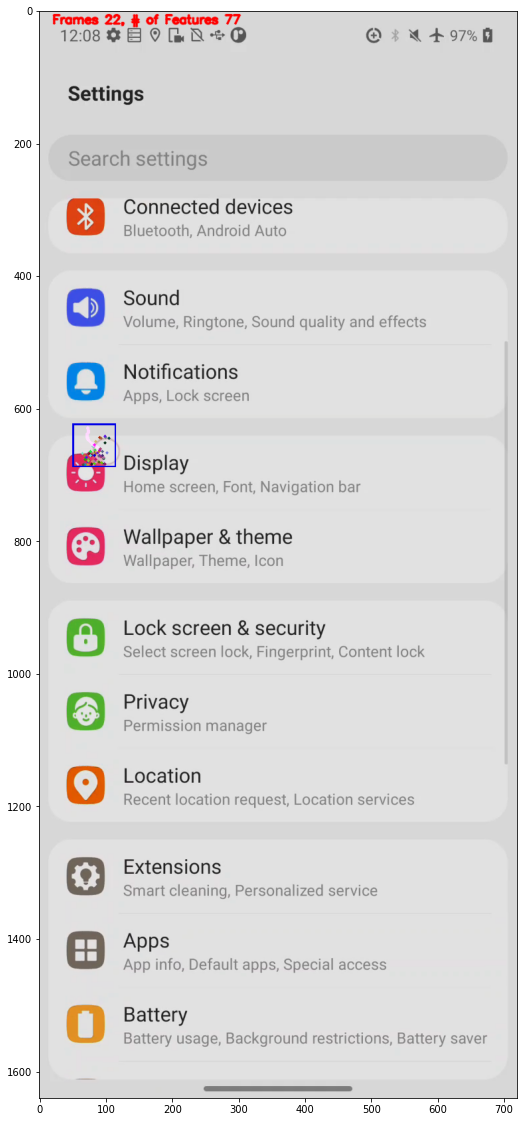

In [89]:
plt.imshow(test_images[21])

In [67]:
print(prevPt.shape, nextPt.shape)

(0,) (2, 1, 2)


99


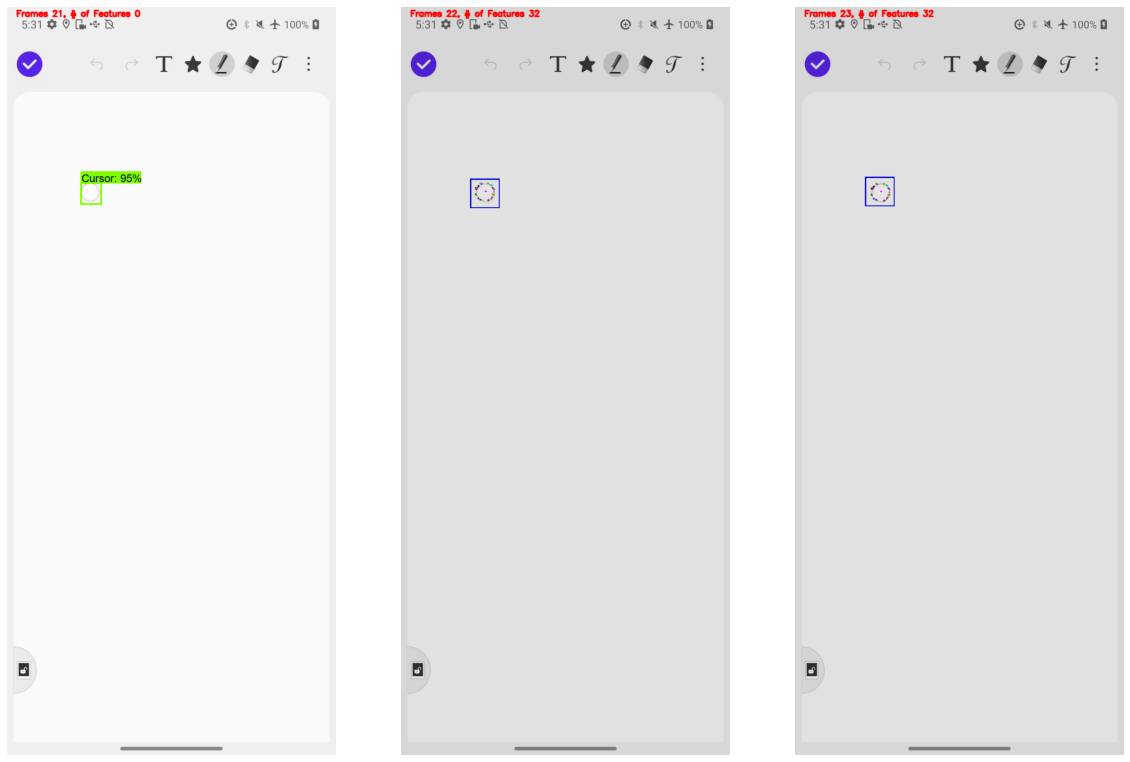

In [65]:
print(len(test_images))
plt.rcParams['figure.figsize'] = [20, 20]

plt.subplot(131)
plt.axis('off')
plt.imshow(test_images[20])
plt.subplot(132)
plt.axis('off')
plt.imshow(test_images[21])
plt.subplot(133)
plt.axis('off')
plt.imshow(test_images[22])

In [42]:
print(prevImage_partial.shape, nextImage_partial.shape)
print(prevPt.shape)

(55, 54) (55, 54)
(0,)


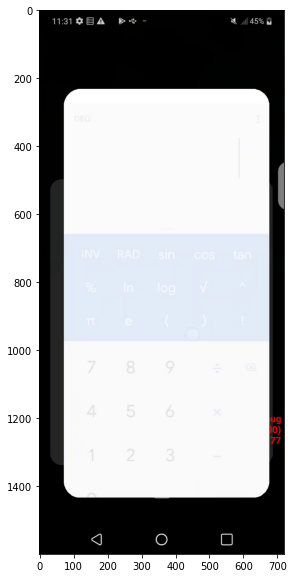

In [45]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.imshow(image_np)

#### 커서의 움직임의 최대치가 어디까지 가능한 것인지, Object Detection Model 만 사용했을 때 
Frame간의 최대 X , Y Movement 를 평가해보자

In [28]:
# This is old version of Script

# 읽은 동영상을 일괄 추론해서 MP4 로 저장하기

import os
import random
import cv2
from tqdm import tqdm

elapsed = []
# setting for Video input
# video_input = '/home001/yousung.choi/projects/project_coordination/workspace/training_demo/images/inference_video/Recording_2021-01-28-15-37-55_V50.mp4'
video_input = '/home001/yousung.choi/projects/project_coordination/tools/1_datasets/1_video/Rainbow_Test/210506_orb_input.mp4'
video_handle = cv2.VideoCapture(video_input)

# setting for Video output
video_output = '/home001/yousung.choi/projects/project_coordination/tools/1_datasets/1_video/Rainbow_Test/210604_test_output.mp4'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(video_output, fourcc, 10.0, (720, 1640))

total_frm = np.arange(int(video_handle.get(cv2.CAP_PROP_FRAME_COUNT)))

# 추적 경로를 그리기 위함
color = np.random.randint(0, 255, (100, 3))
# 추적 선을 그리기 위함
lines = None
# 첫번째 frame 을 위함
not_detected = True
prevImage_partial = None

# image partial offset
offset = 30


# CalcOpticalFlowPyrLK 중지요건 설정 (??)
lk_params = dict(winSize = (15, 15),
                maxLevel = 5,
                criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

test_images = []
test_centers = []

for frm_cnt in tqdm(total_frm):
    if video_handle.isOpened():
        ret, image_cv2 = video_handle.read()
        # test skipping
        if frm_cnt < 20:
            continue
        
        if ret:
            image_np = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)

            if not_detected:
                input_tensor = np.expand_dims(image_np, 0)

                start_time = time.time()
                detections = detect_fn(input_tensor)
                end_time = time.time()
                elapsed.append(end_time - start_time)
                
                ## calculate object counted in output
                obj_cnt = len(np.where(detections['detection_scores'][0].numpy() > 0.8)[0])
            
                if obj_cnt:
                    ymin, xmin, ymax, xmax = detections['detection_boxes'][0][0].numpy()
                    height, width, cl = image_np.shape
                    ymin = int(ymin * height)
                    ymax = int(ymax * height)
                    xmin = int(xmin * width)
                    xmax = int(xmax * width)
                    
                    center_point = [int((xmax + xmin)/2), int((ymax + ymin)/2)]
                    test_centers.append(center_point)
                                   
                    # 현재 Frame update with detections
                    viz_utils.visualize_boxes_and_labels_on_image_array(
                          image_np,
                          detections['detection_boxes'][0].numpy(),
                          detections['detection_classes'][0].numpy().astype(np.int32),
                          detections['detection_scores'][0].numpy(),
                          category_index,
                          use_normalized_coordinates=True,
                          max_boxes_to_draw=200,
                          min_score_thresh=.80,
                          agnostic_mode=False)
                    
                    cv2.circle(image_np, (center_point[0], center_point[1]), 2, (255, 0, 0), -1)                    

            ## Add frm count in frame
            cv2.putText(image_np, 'Frames {0:1d}'.format(frm_cnt+1), (20,20), cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,0,0),2,cv2.LINE_AA)
                
            out.write(image_np)

video_handle.release()
out.release()

mean_elapsed = sum(elapsed) / float(len(elapsed))
print('Elapsed time: ' + str(mean_elapsed) + ' second per image')

print('Total frm cnt : ', frm_cnt)



100%|██████████| 100/100 [00:15<00:00,  6.66it/s]

Elapsed time: 0.13294964134693146 second per image
Total frm cnt :  99


In [29]:
len(test_centers)

71

In [43]:
test_centers_np = np.array(test_centers)
print(test_centers_np.shape)
print(test_centers[-21:])


(71, 2)
[[572, 407], [664, 132], [664, 132], [665, 132], [665, 132], [665, 132], [666, 132], [666, 132], [666, 132], [666, 131], [666, 131], [666, 131], [666, 131], [666, 131], [666, 131], [666, 131], [666, 131], [666, 131], [666, 131], [666, 131], [666, 131]]


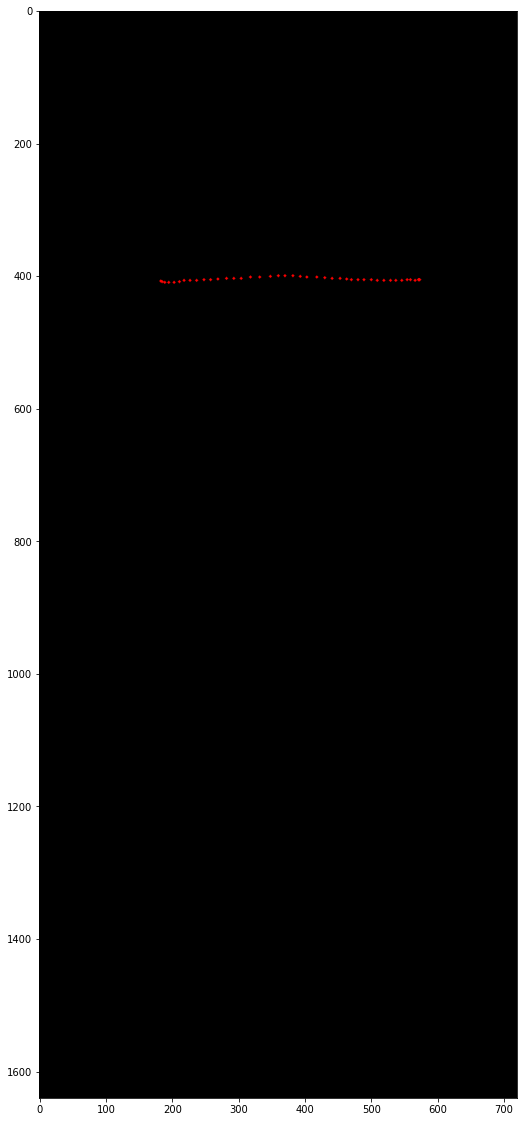

In [47]:
canvas = np.zeros_like(image_np)
for i, (x, y) in enumerate(test_centers):
    if i < 50:
        cv2.circle(canvas, (x, y), 2, (255, 0, 0), -1)
    

plt.imshow(canvas)

In [48]:
diffs = []
for i, (x, y) in enumerate(test_centers_np):
    if i == 0:
        continue
    if i > 50:
        break
    
    x_diff = x - test_centers_np[i-1, 0]
    y_diff = y - test_centers_np[i-1, 1]
    
    diffs.append([x_diff, y_diff])

16


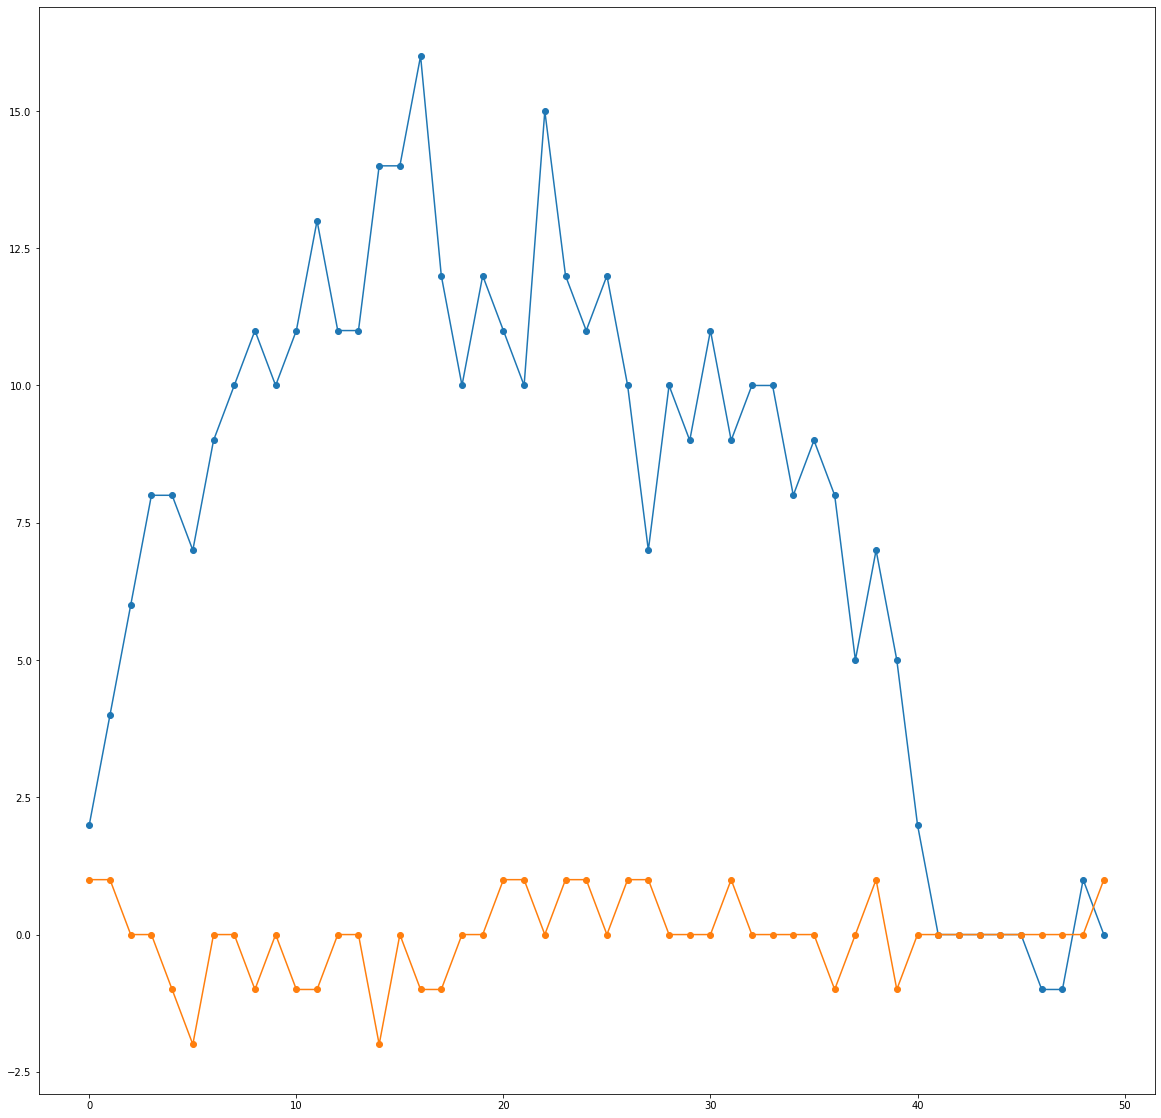

In [57]:
diffs_np = np.array(diffs)
plt.plot(diffs_np[:,0], '-o')
plt.plot(diffs_np[:,1], '-o')
print(diffs_np[:,0].max())

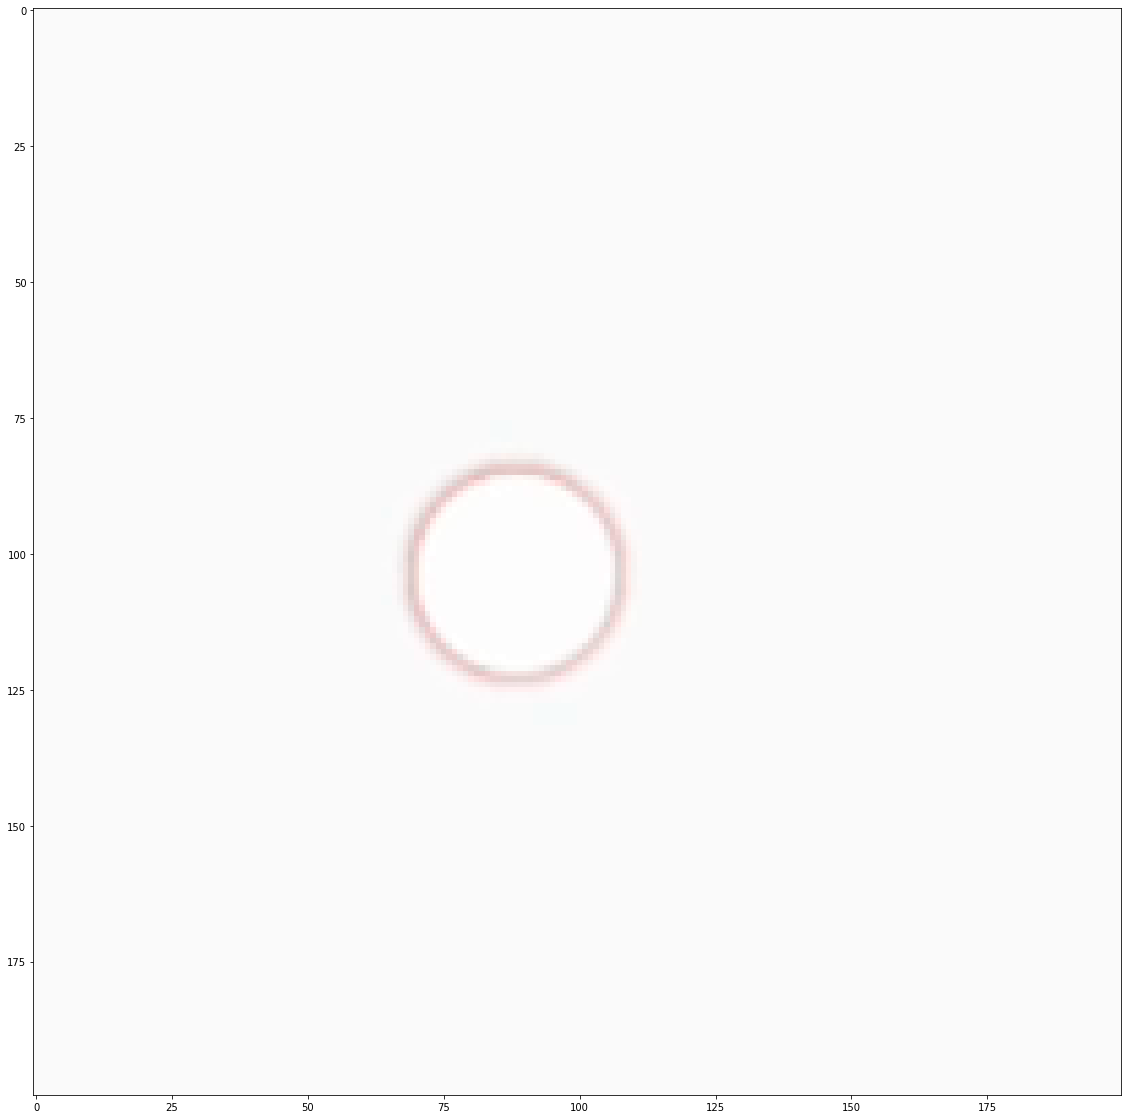

In [102]:
plt.imshow(test_images[50][300:500, 400:600, :])

desc1.shape: (242, 61)
desc1.dtype: uint8


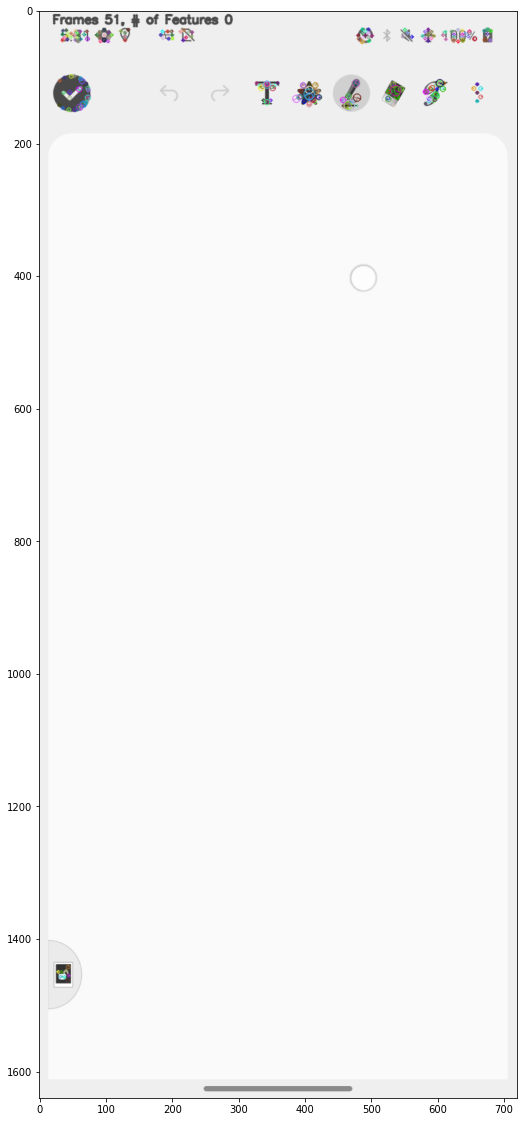

In [114]:
# src1 = test_images[50][300:500, 400:600, :].copy()
src1 = test_images[50].copy()
src1 = cv2.cvtColor(src1, cv2.COLOR_RGB2GRAY)

feature = cv2.AKAZE_create()
#feature = cv2.AKAZE_create()

# 특징점 검출 및 기술자 계산
kp1 = feature.detect(src1) # 디텍트
_, desc1 = feature.compute(src1, kp1) # 컴퓨트


# 반환값 세이프랑 타입을 출력
print('desc1.shape:', desc1.shape) # 카제 (3159, 64) 어카제 2418,61 ORB (500,32)
print('desc1.dtype:', desc1.dtype) # 카제 float32    어카제 unit8   ORB unit8


# 검출된 특징점 출력 영상 생성
dst1 = cv2.drawKeypoints(src1, kp1, None,
                         flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(dst1)

In [127]:
kps = get_features3(src1)
te_draw = test_images[50].copy()
print(kps.shape)
for i, p in enumerate(kps):
        px, py = p.ravel()

        # 새로운 코너에 점그리기
        cv2.circle(te_draw, (px, py), 2, color[i%100].tolist(), -1)
        


(242, 1, 2)


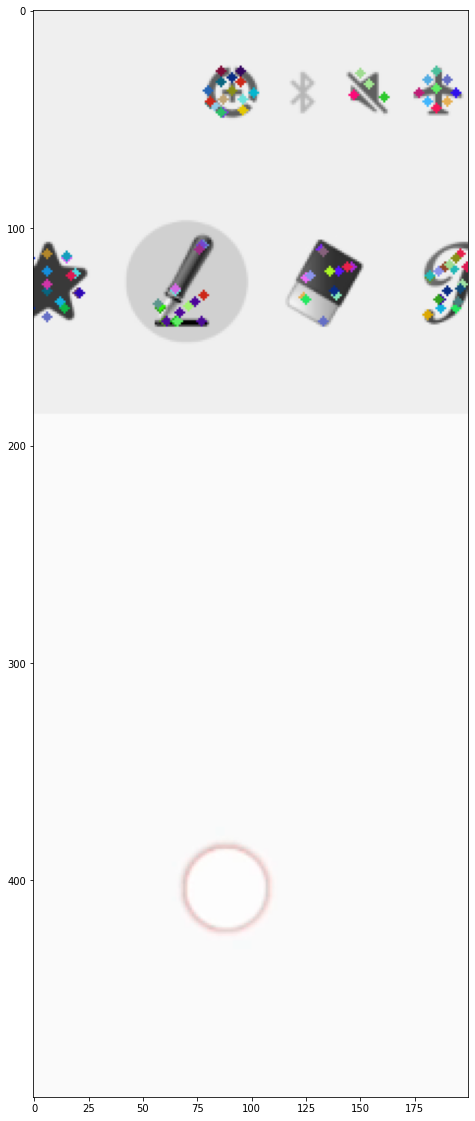

In [130]:
plt.imshow(te_draw[0:500, 400:600, :])